# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

In [306]:
import numpy as np
import random
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from matplotlib import pylab as plt
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import accuracy_score

## Задача 1

Рассмотрим "распределенную" задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число "переданной информации" от устройств к серверу). Сделайте вывод.

In [394]:
# Генерация диагональной матрицы
def gen_matrix_diag(d, mu, L, s):
    np.random.seed(s)
    diag = mu + (L - mu) * np.random.sample(d)
    A = np.diag(diag)
    A[0][0] = L
    A[d - 1][d - 1] = mu
    return A

# Генерация матрицы
def gen_matrix(d, mu, L, s):
    np.random.seed(s)
    B = np.random.sample((d, d))
    Q, _ = np.linalg.qr(B)
    C = gen_matrix_diag(d, mu, L, s)
    A = Q @ C @ Q.T
    return A

In [395]:
# Целевая функция
def f(x):
    A_summa = np.zeros([d, d])
    b_summa = np.zeros(d)
    for i in range(n):
        A_summa += A_list[i]
        b_summa += b_list[i]
    return 1 / (2 * n) * (x.T @ A_summa @ x - b_summa.T @ x)

# Градиент функции
def grad_f(x):
    A_summa = np.zeros([d, d])
    b_summa = np.zeros(d)
    for i in range(n):
        A_summa += A_list[i]
        b_summa += b_list[i]
    return 1 / n * (A_summa @ x - b_summa)

# Компонента функции
def f_i(x, i):
    return 1/2 * x.T @ A_list[i] @ x - b_list.T[i] @ x

# Компонента градиента функции
def grad_f_i(x, i):
    return A_list[i] @ x - b_list[i]

In [396]:
s = 2
n = 10
L = 1000
mu = 1
d = 100
m = 100

np.random.seed(s)
A_list = []
b_list = []
for i in range(n):
    np.random.seed(s + i)
    A_list.append(gen_matrix(d, mu, L, s))
    b_list.append(np.random.sample(d))
x_0 = np.random.sample(d)

In [397]:
def DGDC(grad_f_i, Q, x_0, gamma, m, iteration, epsilon=10**-7, c=1):
    
    x_now = x_0
    errors = []
    
    errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)
    
    for k in trange(iteration, colour='green'):
        
        grad = np.zeros(d)
        for i in range(n):
            grad += Q(grad_f_i(x_now, i), m)
        
        x_next = x_now - gamma(k, m, c) / n * grad
        x_now = x_next
        
        errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)
  
        if errors[-1] < epsilon:
            break
            
    return x_now, errors

Теоритический шаг для $\text{Rand}m\%$ $\text{Compression}$ равен:

$$\gamma_k = \dfrac{1}{4L(1 + \frac{2 \cdot 100}{nm})}$$

Для подбора наилучшего шага рассмотрим:

$$\gamma_k = \dfrac{с}{4L(1 + \frac{2 \cdot 100}{nm})},$$

затем выберем лучший.

Количество переданной информации на каждом шаге равно $\frac{ndm}{100}$ (в нашем случае $nm$).

In [398]:
def gamma_comp(k, m, c=1):
    return c / (4 * L * (1 + 200 / (n * m)))

def Q_rand(grad_f, m):
    index = random.sample(range(d), m)
    Q_grad = np.zeros(grad_f.size)
    for i in index:
        Q_grad[i] = grad_f[i]
    return Q_grad

In [220]:
_, errors_1 = DGDC(grad_f_i, Q_rand, x_0, gamma_comp, m, 10**4, c=0.5)
_, errors_2 = DGDC(grad_f_i, Q_rand, x_0, gamma_comp, m, 10**4, c=1)
_, errors_3 = DGDC(grad_f_i, Q_rand, x_0, gamma_comp, m, 10**4, c=4)
_, errors_4 = DGDC(grad_f_i, Q_rand, x_0, gamma_comp, m, 10**4, c=7)
_, errors_5 = DGDC(grad_f_i, Q_rand, x_0, gamma_comp, m, 10**4, c=9)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

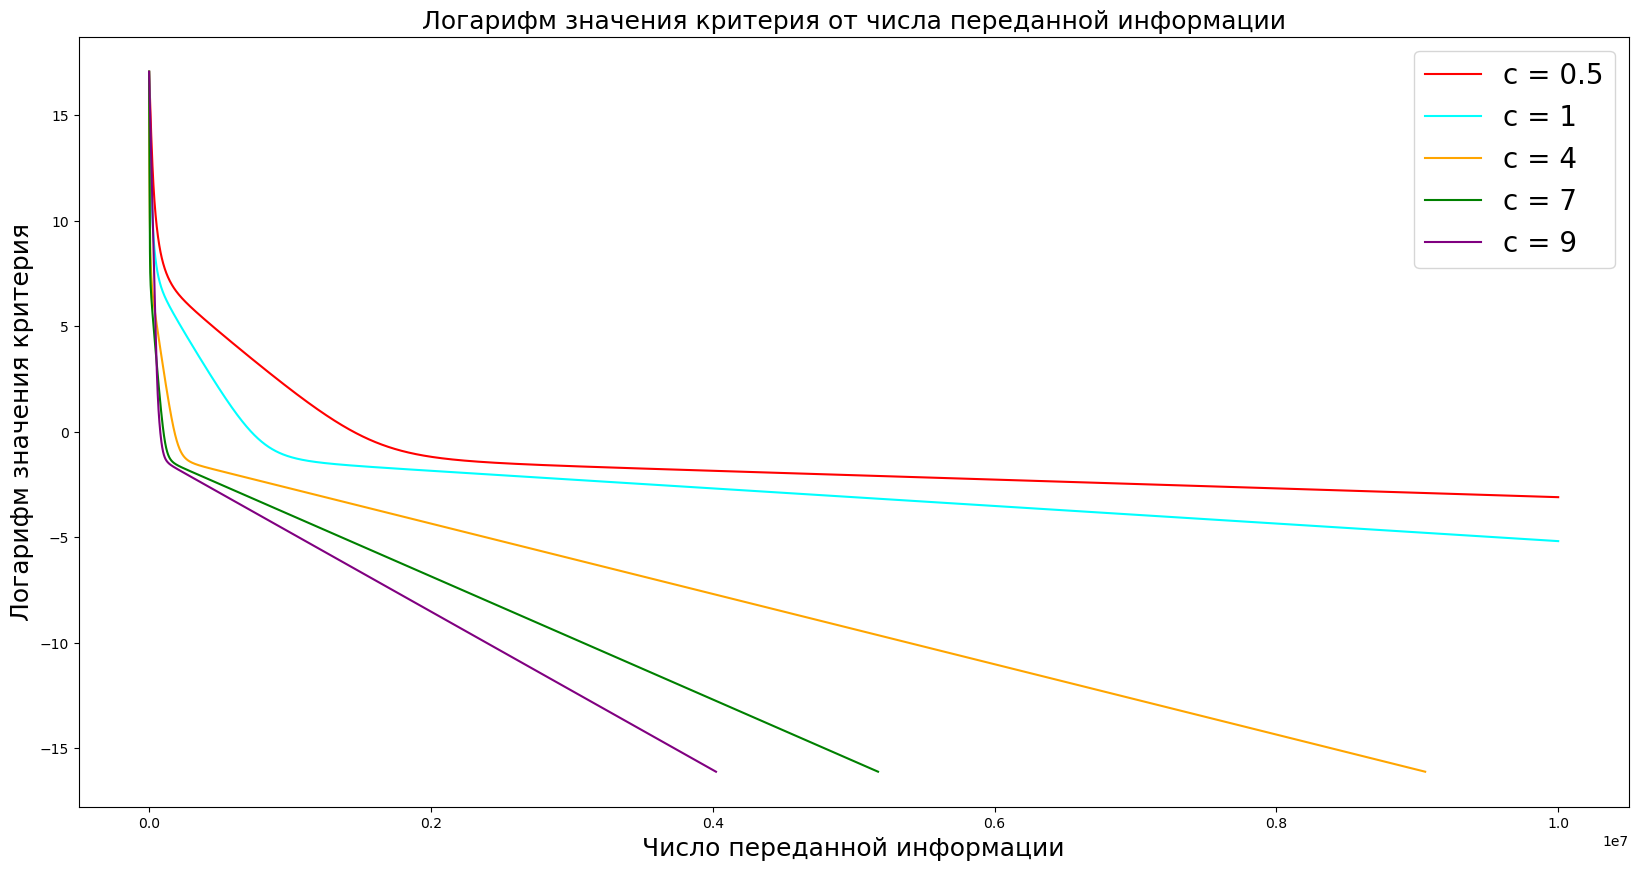

In [231]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_1) * n * m, n * m)), np.log(errors_1), "red", label = "c = 0.5")
plt.plot(np.array(range(0, len(errors_2) * n * m, n * m)), np.log(errors_2), "cyan", label = "c = 1" )
plt.plot(np.array(range(0, len(errors_3) * n * m, n * m)), np.log(errors_3), "orange", label = "c = 4")
plt.plot(np.array(range(0, len(errors_4) * n * m, n * m)), np.log(errors_4), "green", label = "c = 7")
plt.plot(np.array(range(0, len(errors_5) * n * m, n * m)), np.log(errors_5), "purple", label = "c = 9")
plt.title("Логарифм значения критерия от числа переданной информации", fontsize = 18)
plt.xlabel("Число переданной информации", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Как мы видим лучше всего сходится при $c = 9$, при больших $c$ рассходится, но возьмем $c = 7$, для устойчивости.

In [238]:
_, errors_6 = DGDC(grad_f_i, Q_rand, x_0, gamma_comp, 1, 100 * 10**4, c=7)
_, errors_7 = DGDC(grad_f_i, Q_rand, x_0, gamma_comp, 5, 20 * 10**4, c=7)
_, errors_8 = DGDC(grad_f_i, Q_rand, x_0, gamma_comp, 10, 10 * 10**4, c=7)
_, errors_9 = DGDC(grad_f_i, Q_rand, x_0, gamma_comp, 20, 5 * 10**4, c=7)
_, errors_10 = DGDC(grad_f_i, Q_rand, x_0, gamma_comp, 100, 1 * 10**4, c=7)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

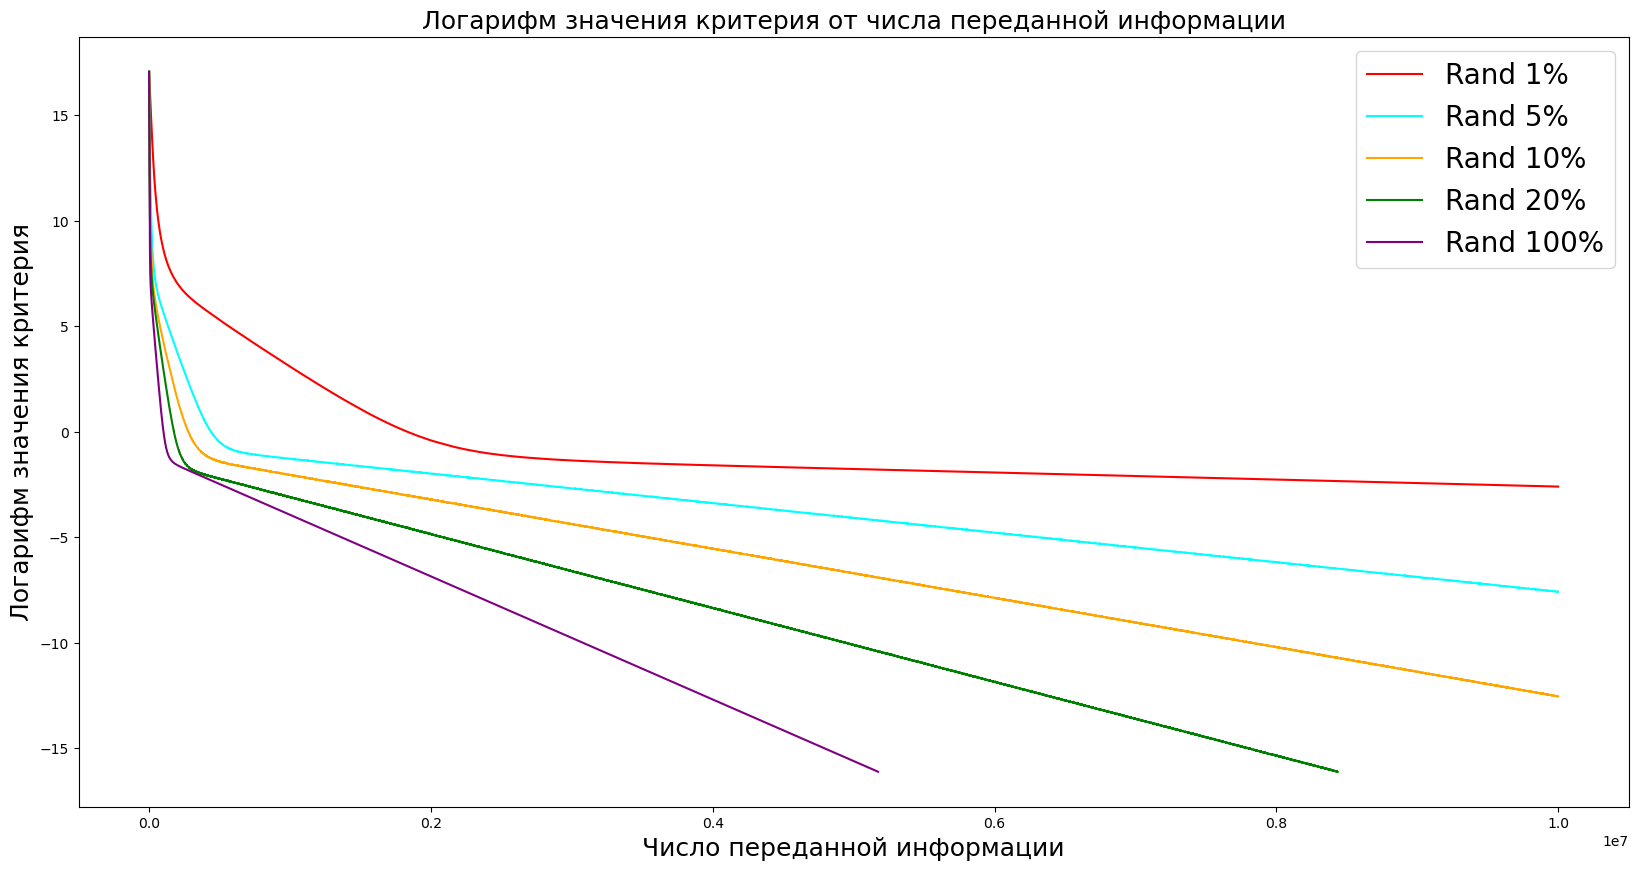

In [239]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_6) * n * 1, n * 1)), np.log(errors_6), "red", label = "Rand 1%")
plt.plot(np.array(range(0, len(errors_7) * n * 5, n * 5)), np.log(errors_7), "cyan", label = "Rand 5%")
plt.plot(np.array(range(0, len(errors_8) * n * 10, n * 10)), np.log(errors_8), "orange", label = "Rand 10%")
plt.plot(np.array(range(0, len(errors_9) * n * 20, n * 20)), np.log(errors_9), "green", label = "Rand 20%")
plt.plot(np.array(range(0, len(errors_10) * n * 100, n * 100)), np.log(errors_10), "purple", label = "Rand 100%")
plt.title("Логарифм значения критерия от числа переданной информации", fontsize = 18)
plt.xlabel("Число переданной информации", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Как мы видим $1\%$ мало, но уже начиная $5\%$ сходится хорошо.

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [400]:
def DGDEF(grad_f_i, Q, x_0, gamma, m, iteration, epsilon=10**-7, c=1):
    
    x_now = x_0
    e = np.zeros([n, d])
    g = np.zeros([n, d])
    errors = []
    
    errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)
    
    for k in trange(iteration, colour='green'):
        
        for i in range(n):
            g[i] = Q(e[i] + gamma(k, m, c) * grad_f_i(x_now, i), m)
            e[i] += gamma(k, m, c) * grad_f_i(x_now, i) - g[i]
         
        grad = np.zeros(d)
        for i in range(n):
            grad += g[i]
        
        x_next = x_now - 1 / n * grad
        x_now = x_next
        
        errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)
  
        if errors[-1] < epsilon:
            break
            
    return x_now, errors

Теоритический шаг для $\text{Top}m\%$ $\text{Compression}$ равен:

$$\gamma_k = \dfrac{1}{4L(1 + \frac{2 \cdot 100}{nm})}$$

Оптимальным шагом будет (из пункта __a)__):

$$\gamma_k = \dfrac{7}{4L(1 + \frac{2 \cdot 100}{nm})}$$

Теоритический шаг для $\text{Top}m\%$ $\text{Error feedback}$ равен:

$$\gamma_k = \dfrac{1}{4L(1 + \frac{2 \cdot 100}{nm})}$$

Для подбора наилучшего шага рассмотрим:

$$\gamma_k = \dfrac{с}{4L(1 + \frac{2 \cdot 100}{nm})},$$

затем выберем лучший.

Количество переданной информации на каждом шаге равно $\frac{ndm}{100}$ (в нашем случае $nm$).

In [401]:
m = 10

def gamma_error(k, m, c=1):
    return c / (4 * L * (1 + 200 / (n * m)))

def Q_top(grad_f, m):
    index = sorted(enumerate(np.abs(grad_f)), key=lambda x : -x[1])
    Q_grad = np.zeros(grad_f.size)
    for i in range(m):
        Q_grad[index[i][0]] = grad_f[index[i][0]]
    return Q_grad

In [402]:
_, errors_11 = DGDEF(grad_f_i, Q_top, x_0, gamma_error, m, 10**4, c=0.5)
_, errors_12 = DGDEF(grad_f_i, Q_top, x_0, gamma_error, m, 10**4, c=1)
_, errors_13 = DGDEF(grad_f_i, Q_top, x_0, gamma_error, m, 10**4, c=4)
_, errors_14 = DGDEF(grad_f_i, Q_top, x_0, gamma_error, m, 10**4, c=5)
_, errors_15 = DGDEF(grad_f_i, Q_top, x_0, gamma_error, m, 10**4, c=7)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

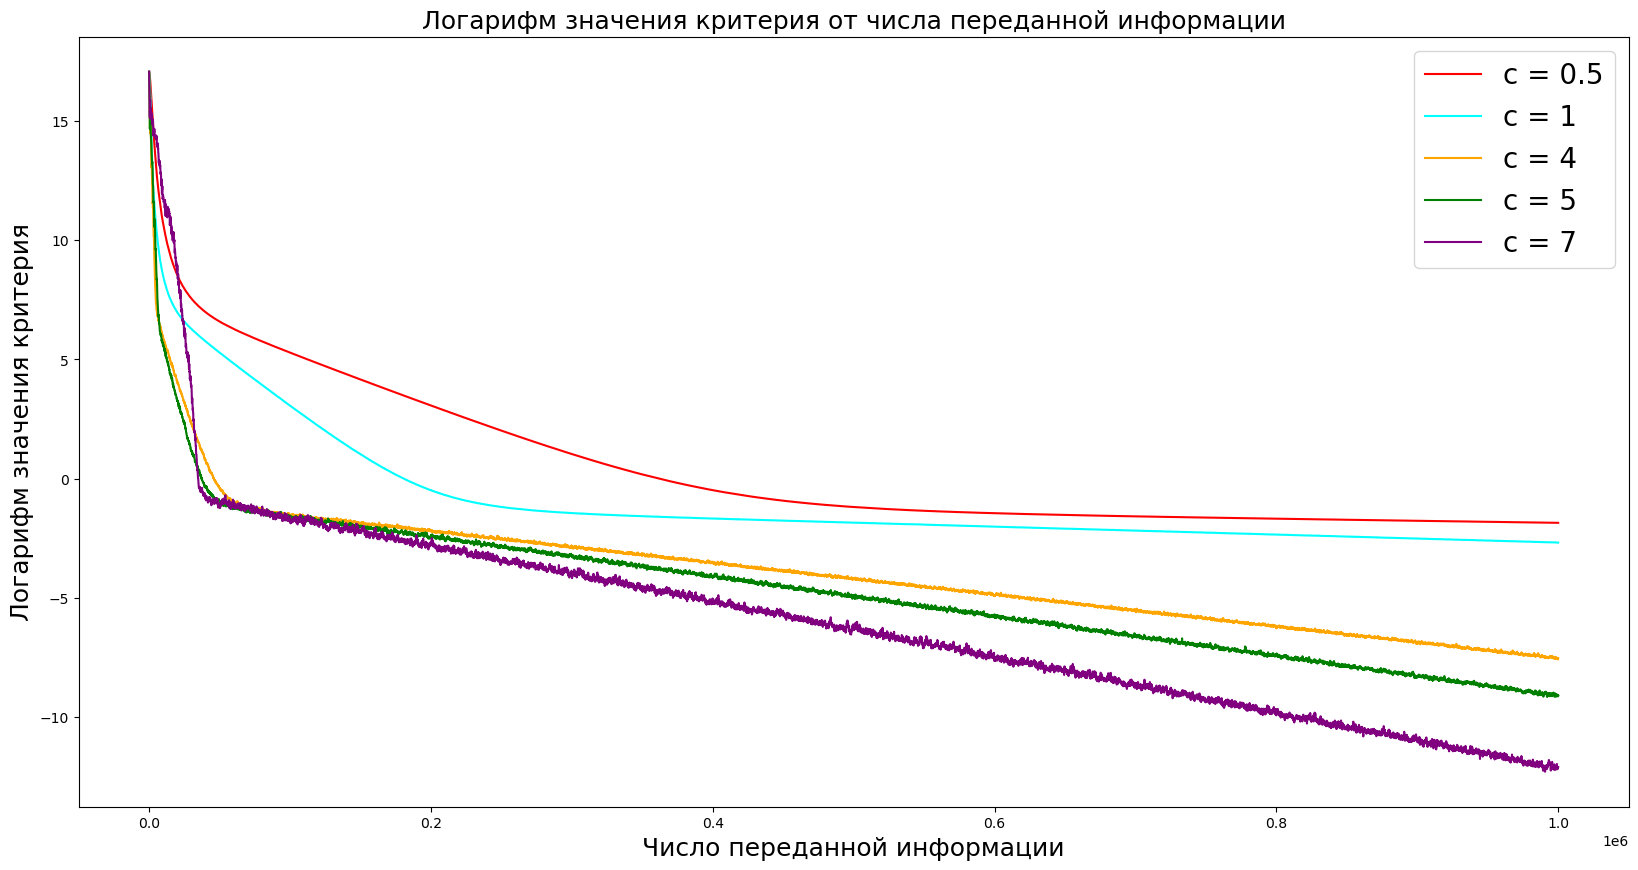

In [321]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_11) * n * m, n * m)), np.log(errors_11), "red", label = "c = 0.5")
plt.plot(np.array(range(0, len(errors_12) * n * m, n * m)), np.log(errors_12), "cyan", label = "c = 1" )
plt.plot(np.array(range(0, len(errors_13) * n * m, n * m)), np.log(errors_13), "orange", label = "c = 4")
plt.plot(np.array(range(0, len(errors_14) * n * m, n * m)), np.log(errors_14), "green", label = "c = 5")
plt.plot(np.array(range(0, len(errors_15) * n * m, n * m)), np.log(errors_15), "purple", label = "c = 7")
plt.title("Логарифм значения критерия от числа переданной информации", fontsize = 18)
plt.xlabel("Число переданной информации", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Как мы видим лучше всего сходится при $c = 7$.

In [326]:
_, errors_16 = DGDC(grad_f_i, Q_rand, x_0, gamma_comp, m, 10**5, c=7)
_, errors_17 = DGDC(grad_f_i, Q_top, x_0, gamma_comp, m, 10**5, c=7)
_, errors_18 = DGDEF(grad_f_i, Q_top, x_0, gamma_error, m, 10**5, c=7)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

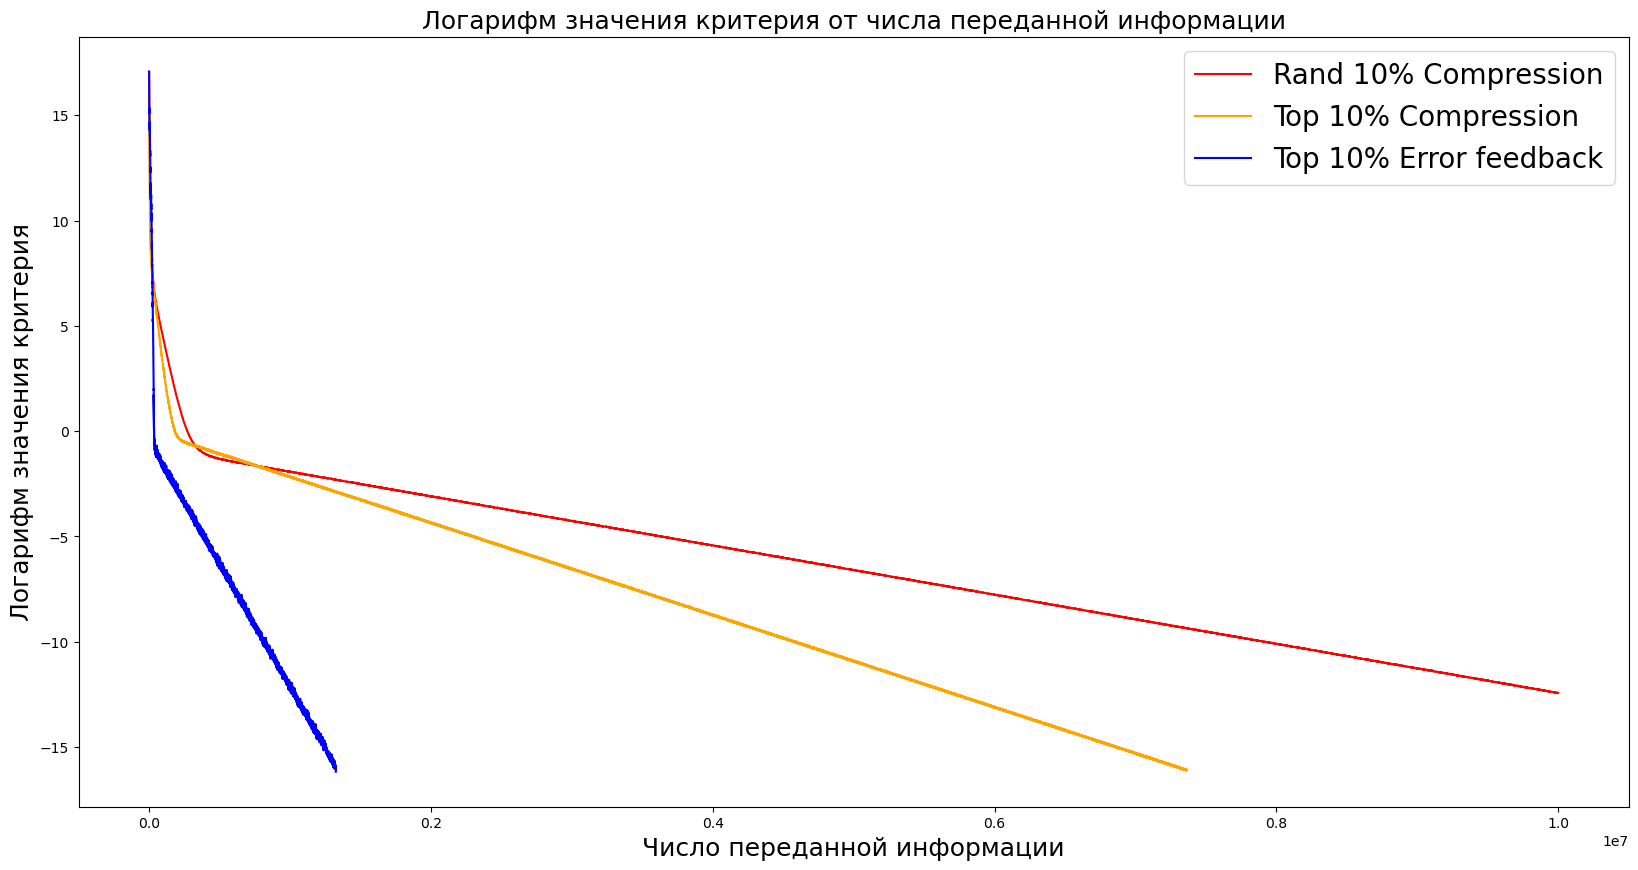

In [327]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_16) * n * m, n * m)), np.log(errors_16), "red", label = "Rand 10% Compression")
plt.plot(np.array(range(0, len(errors_17) * n * m, n * m)), np.log(errors_17), "orange", label = "Top 10% Compression")
plt.plot(np.array(range(0, len(errors_18) * n * m, n * m)), np.log(errors_18), "blue", label = "Top 10% Error feedback")
plt.title("Логарифм значения критерия от числа переданной информации", fontsize = 18)
plt.xlabel("Число переданной информации", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

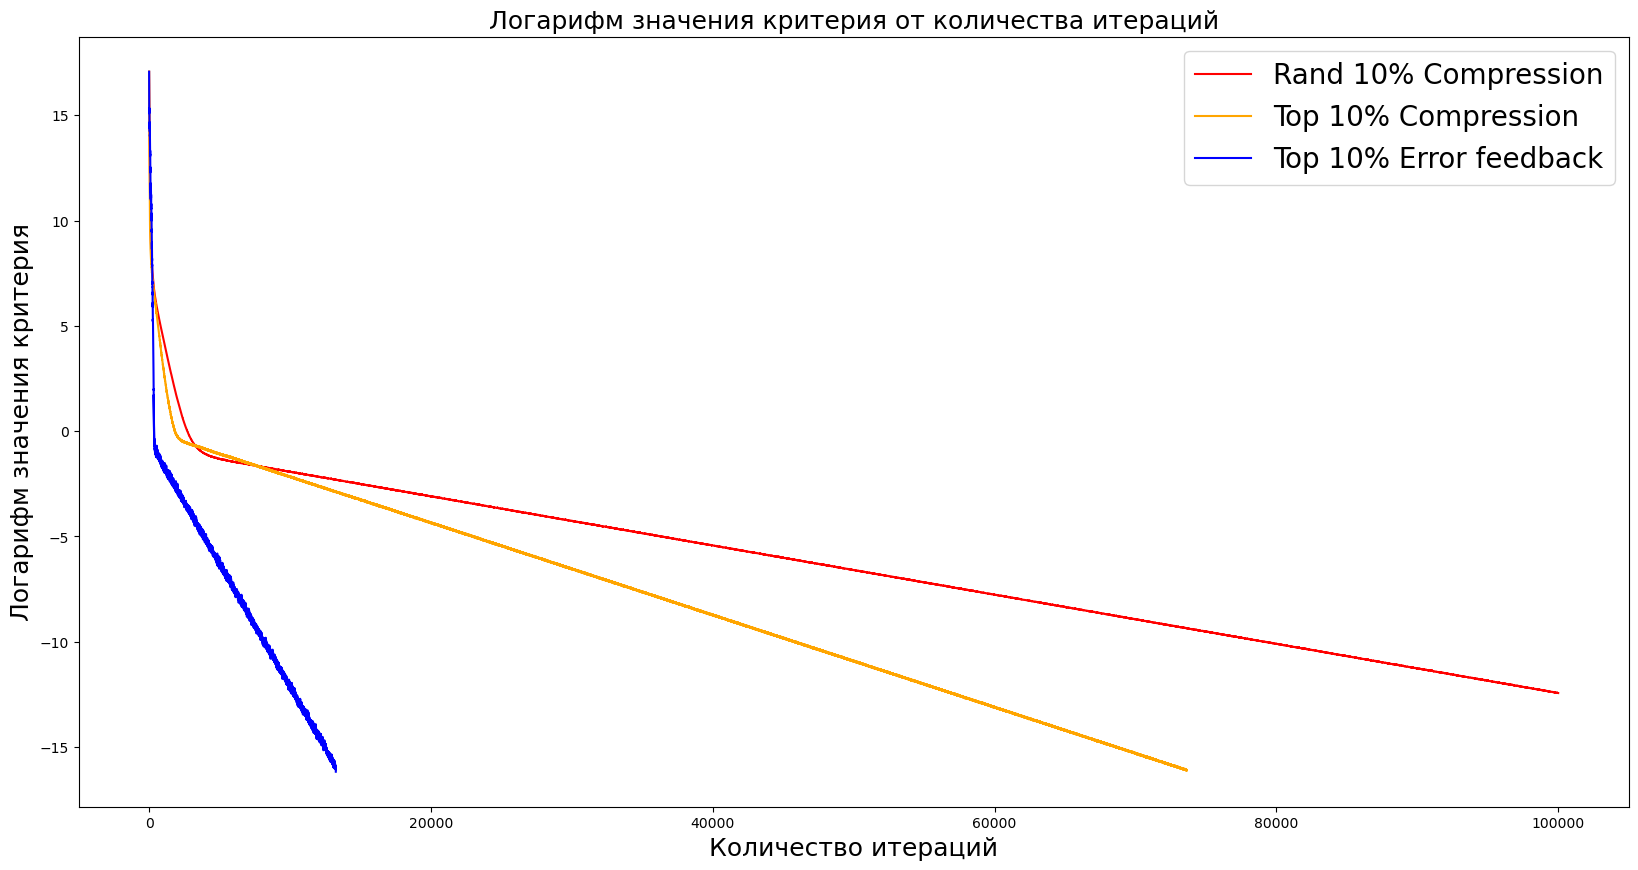

In [328]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(len(errors_16))), np.log(errors_16), "red", label = "Rand 10% Compression")
plt.plot(np.array(range(len(errors_17))), np.log(errors_17), "orange", label = "Top 10% Compression")
plt.plot(np.array(range(len(errors_18))), np.log(errors_18), "blue", label = "Top 10% Error feedback")
plt.title("Логарифм значения критерия от количества итераций", fontsize = 18)
plt.xlabel("Количество итераций", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Как мы видим лучше всего сходится $\text{Top} 10\%$ Error feedback. $\text{Top} 10\%$ Compression сходится лучше, чем $\text{Rand} 10\%$ Compression, что ожидаемо.

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [454]:
dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
N, d = X.shape

In [455]:
seed = 4

np.random.seed(seed)
np.random.shuffle(X)
X_train = X[:(N * 4) // 5]
X_test = X[(N * 4) // 5:]

np.random.seed(seed)
np.random.shuffle(y)
y_train = y[:(N * 4) // 5]
y_test = y[(N * 4) // 5:]

In [509]:
#Частичная фукция
def f_i(x, i):
    B = F[i * b : (i + 1) * b]
    c = a[i * b : (i + 1) * b]
    return np.linalg.norm(B @ w - c, ord = 2)**2

#Градиент функции 
def grad_f(w):
    summa = np.zeros(d)
    for i in range(n):
        summa += grad_f_i(w, i)
    return 2 / F.shape[0] * summa

#Частичный градиент
def grad_f_i(w, i):
    B = F[i * b : (i + 1) * b]
    c = a[i * b : (i + 1) * b]
    return 2 * (B.T @ (B @ w - c))

#prox - функция
def prox(w, gamma):
    return max(1 - gamma * L / (1000 * np.linalg.norm(w, ord=2)), 0) * w

In [510]:
F = X_train
a = y_train
n = 10
b = a.size // n

seed = 1
np.random.seed(s)
w_0 = np.random.sample(d)

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

In [511]:
def DIANA(grad_f_i, Q, x_0, gamma, alpha, m, iteration, epsilon=10**-7, c=1):
    
    x_now = x_0
    h = np.zeros([n, d])
    delta = np.zeros([n, d])
    g = np.zeros([n, d])
    errors = []
    errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)
    
    for k in trange(iteration, colour='green'):
 
        delta_0 = 0
        g_0 = 0
        h_0 = 0
        for i in range(n):
            delta[i] = Q(grad_f_i(x_now, i) - h[i], m)
            g[i] = h[i] + delta[i]
            h[i] += alpha(k, m) * delta[i]
            delta_0 += delta[i]
            g_0 += g[i]
            h_0 += h_0
            
        delta_0 = delta_0 / n
        g_0 = g_0 / n
        h_0 = h_0 / n
        
        x_next = prox(x_now - gamma(k, m, c) * g_0, gamma(k, m, c))
        x_now = x_next
         
        errors.append(np.linalg.norm(grad_f(x_now), ord=2)**2)
  
        if errors[-1] < epsilon:
            break
            
    return x_now, errors

Теоритический шаг для $\text{Top}m\%$ / $\text{Rand}m\%$ $\text{DIANA}$ равен:

$$\gamma_k = \dfrac{1}{4L(1 + \frac{2 \cdot 100}{nm})}$$

Для подбора наилучшего шага рассмотрим:

$$\gamma_k = \dfrac{с}{4L(1 + \frac{2 \cdot 100}{nm})},$$

затем выберем лучший.

Также в методе DIANA есть гиперпараметр $\alpha$:

$$\alpha = \dfrac{m}{100 + m}$$

Количество переданной информации на каждом шаге равно $\frac{ndm}{100}$ (в нашем случае $nm$).

In [512]:
m = 10

def gamma_DIANA(k, m, c=1):
    return c / (4 * L * (1 + 200 / n * m))

def alpha_DIANA(k, m):
    return m / (100 + m)

In [528]:
_, errors_19 = DIANA(grad_f_i, Q_top, w_0, gamma_DIANA, alpha_DIANA, m, 10**4, c=0.5)
_, errors_20 = DIANA(grad_f_i, Q_top, w_0, gamma_DIANA, alpha_DIANA, m, 10**4, c=1)
_, errors_21 = DIANA(grad_f_i, Q_top, w_0, gamma_DIANA, alpha_DIANA, m, 10**4, c=50)
_, errors_22 = DIANA(grad_f_i, Q_top, w_0, gamma_DIANA, alpha_DIANA, m, 10**4, c=100)
_, errors_23 = DIANA(grad_f_i, Q_top, w_0, gamma_DIANA, alpha_DIANA, m, 10**4, c=150)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

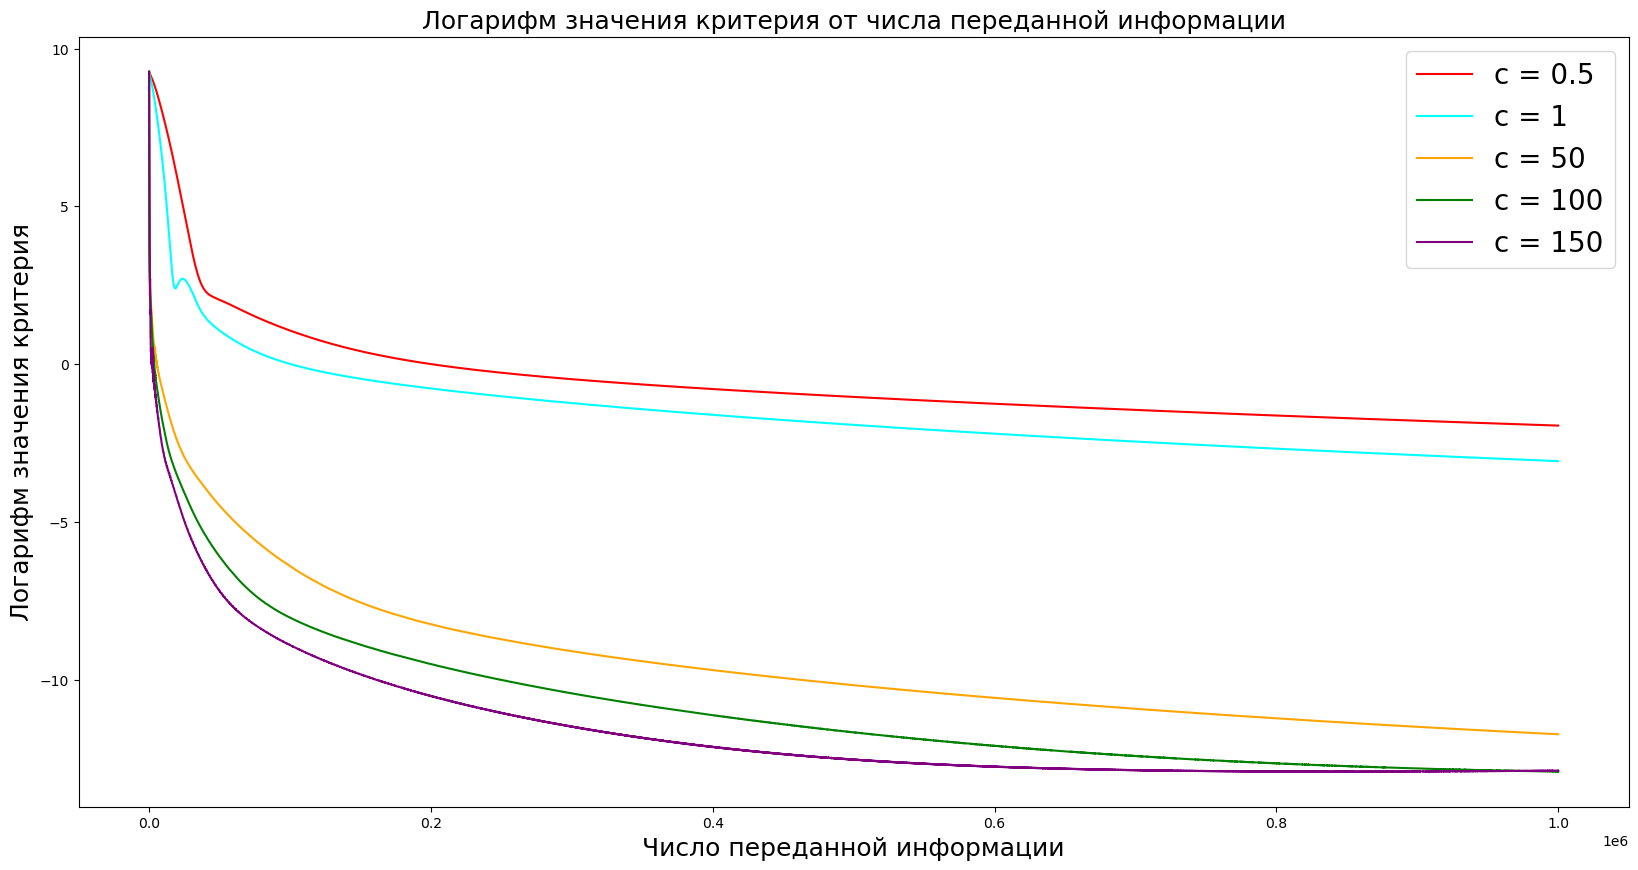

In [530]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_19) * n * m, n * m)), np.log(errors_19), "red", label = "c = 0.5")
plt.plot(np.array(range(0, len(errors_20) * n * m, n * m)), np.log(errors_20), "cyan", label = "c = 1")
plt.plot(np.array(range(0, len(errors_21) * n * m, n * m)), np.log(errors_21), "orange", label = "c = 50")
plt.plot(np.array(range(0, len(errors_22) * n * m, n * m)), np.log(errors_22), "green", label = "c = 100")
plt.plot(np.array(range(0, len(errors_23) * n * m, n * m)), np.log(errors_23), "purple", label = "c = 150")
plt.title("Логарифм значения критерия от числа переданной информации", fontsize = 18)
plt.xlabel("Число переданной информации", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Как мы видим, лучше всего сходится при $c = 150$, но возьмем $c = 100$ для устойчивости.

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [571]:
_, errors_24 = DGDC(grad_f_i, Q_rand, w_0, gamma_comp, m, 10**4, c=2)
_, errors_25 = DGDEF(grad_f_i, Q_rand, w_0, gamma_error, m, 10**4, c=0.2)
_, errors_26 = DIANA(grad_f_i, Q_rand, w_0, gamma_DIANA, alpha_DIANA, m, 10**4, c=100)
_, errors_27 = DGDC(grad_f_i, Q_top, w_0, gamma_comp, m, 10**4, c=2)
_, errors_28 = DGDEF(grad_f_i, Q_top, w_0, gamma_error, m, 10**4, c=0.5)
_, errors_29 = DIANA(grad_f_i, Q_top, w_0, gamma_DIANA, alpha_DIANA, m, 10**4, c=100)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Параметры, которые мы получили в предыдущих пунктах, пришлось оптимизировать и менять (уменьшать).

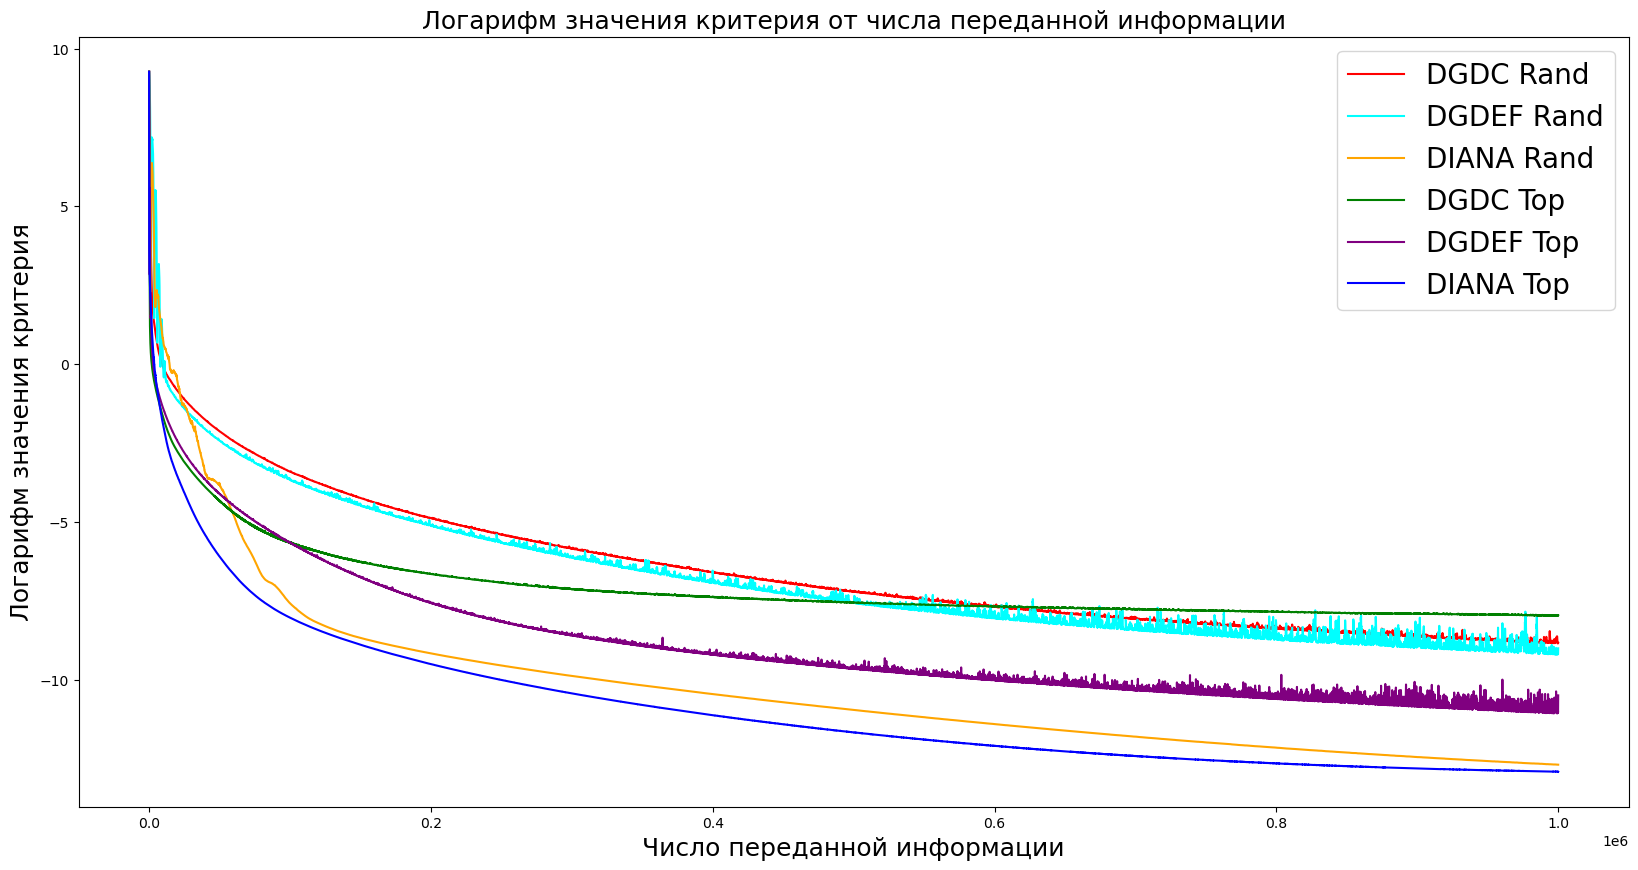

In [589]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_24) * n * m, n * m)), np.log(errors_24), "red", label = "DGDC Rand")
plt.plot(np.array(range(0, len(errors_25) * n * m, n * m)), np.log(errors_25), "cyan", label = "DGDEF Rand")
plt.plot(np.array(range(0, len(errors_26) * n * m, n * m)), np.log(errors_26), "orange", label = "DIANA Rand")
plt.plot(np.array(range(0, len(errors_27) * n * m, n * m)), np.log(errors_27), "green", label = "DGDC Top")
plt.plot(np.array(range(0, len(errors_28) * n * m, n * m)), np.log(errors_28), "purple", label = "DGDEF Top")
plt.plot(np.array(range(0, len(errors_29) * n * m, n * m)), np.log(errors_29), "blue", label = "DIANA Top")
plt.title("Логарифм значения критерия от числа переданной информации", fontsize = 18)
plt.xlabel("Число переданной информации", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

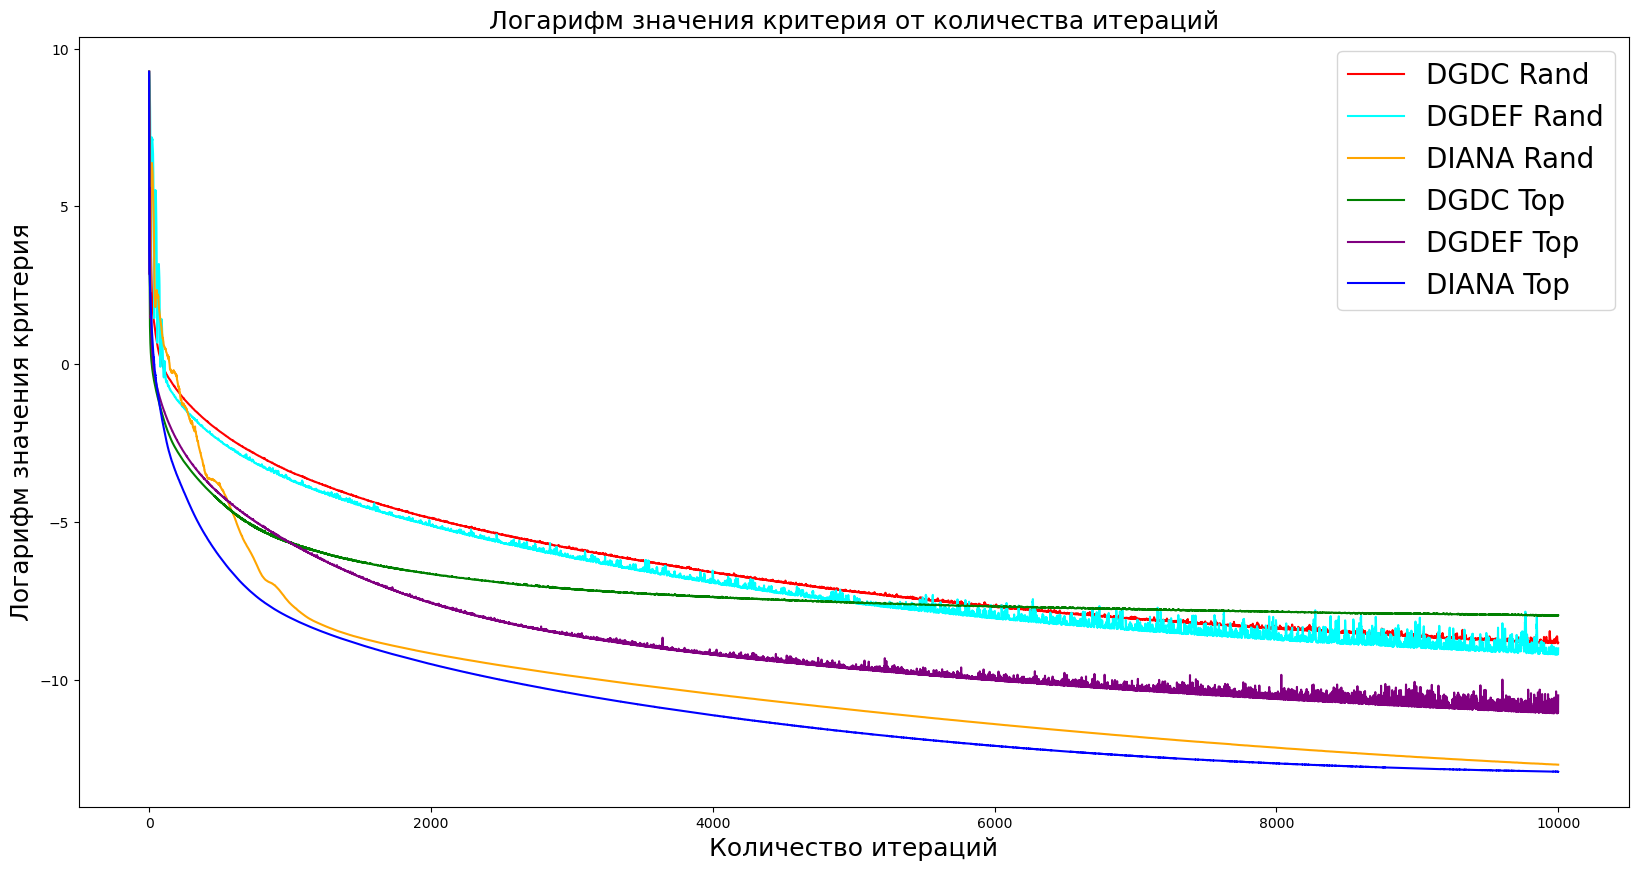

In [590]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(len(errors_24))), np.log(errors_24), "red", label = "DGDC Rand")
plt.plot(np.array(range(len(errors_25))), np.log(errors_25), "cyan", label = "DGDEF Rand")
plt.plot(np.array(range(len(errors_26))), np.log(errors_26), "orange", label = "DIANA Rand")
plt.plot(np.array(range(len(errors_27))), np.log(errors_27), "green", label = "DGDC Top")
plt.plot(np.array(range(len(errors_28))), np.log(errors_28), "purple", label = "DGDEF Top")
plt.plot(np.array(range(len(errors_29))), np.log(errors_29), "blue", label = "DIANA Top")
plt.title("Логарифм значения критерия от количества итераций", fontsize = 18)
plt.xlabel("Количество итераций", fontsize = 18)
plt.ylabel("Логарифм значения критерия", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

In [575]:
def accuracy(y_test, X_test, method, grad_f_i, Q, x_0, gamma, alpha, m, iteration, step):
    accuracy = []
    for i in tqdm(range(1, iteration + 2, step), colour='green'):
        if method == DIANA:
            w, _ = method(grad_f_i, Q, x_0, gamma, alpha, m, i)
        else:
            w, _ = method(grad_f_i, Q, x_0, gamma, m, i)
        y_pred = np.round(X_test @ w)
        accuracy.append(accuracy_score(y_test, y_pred))
    return accuracy

In [577]:
accuracy_1 = accuracy(y_test, X_test, DGDC, grad_f_i, Q_rand, w_0, gamma_comp, None, m, 10000, 1000)
accuracy_2 = accuracy(y_test, X_test, DGDEF, grad_f_i, Q_rand, w_0, gamma_error, None, m, 10000, 1000)
accuracy_3 = accuracy(y_test, X_test, DIANA, grad_f_i, Q_rand, w_0, gamma_DIANA, alpha_DIANA, m, 10000, 1000)
accuracy_4 = accuracy(y_test, X_test, DGDC, grad_f_i, Q_top, w_0, gamma_comp, None, m, 10000, 1000)
accuracy_5 = accuracy(y_test, X_test, DGDEF, grad_f_i, Q_top, w_0, gamma_error, None, m, 10000, 1000)
accuracy_6 = accuracy(y_test, X_test, DIANA, grad_f_i, Q_top, w_0, gamma_DIANA, alpha_DIANA, m, 10000, 1000)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/6001 [00:00<?, ?it/s]

  0%|          | 0/7001 [00:00<?, ?it/s]

  0%|          | 0/8001 [00:00<?, ?it/s]

  0%|          | 0/9001 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/6001 [00:00<?, ?it/s]

  0%|          | 0/7001 [00:00<?, ?it/s]

  0%|          | 0/8001 [00:00<?, ?it/s]

  0%|          | 0/9001 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/6001 [00:00<?, ?it/s]

  0%|          | 0/7001 [00:00<?, ?it/s]

  0%|          | 0/8001 [00:00<?, ?it/s]

  0%|          | 0/9001 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/6001 [00:00<?, ?it/s]

  0%|          | 0/7001 [00:00<?, ?it/s]

  0%|          | 0/8001 [00:00<?, ?it/s]

  0%|          | 0/9001 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/6001 [00:00<?, ?it/s]

  0%|          | 0/7001 [00:00<?, ?it/s]

  0%|          | 0/8001 [00:00<?, ?it/s]

  0%|          | 0/9001 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/6001 [00:00<?, ?it/s]

  0%|          | 0/7001 [00:00<?, ?it/s]

  0%|          | 0/8001 [00:00<?, ?it/s]

  0%|          | 0/9001 [00:00<?, ?it/s]

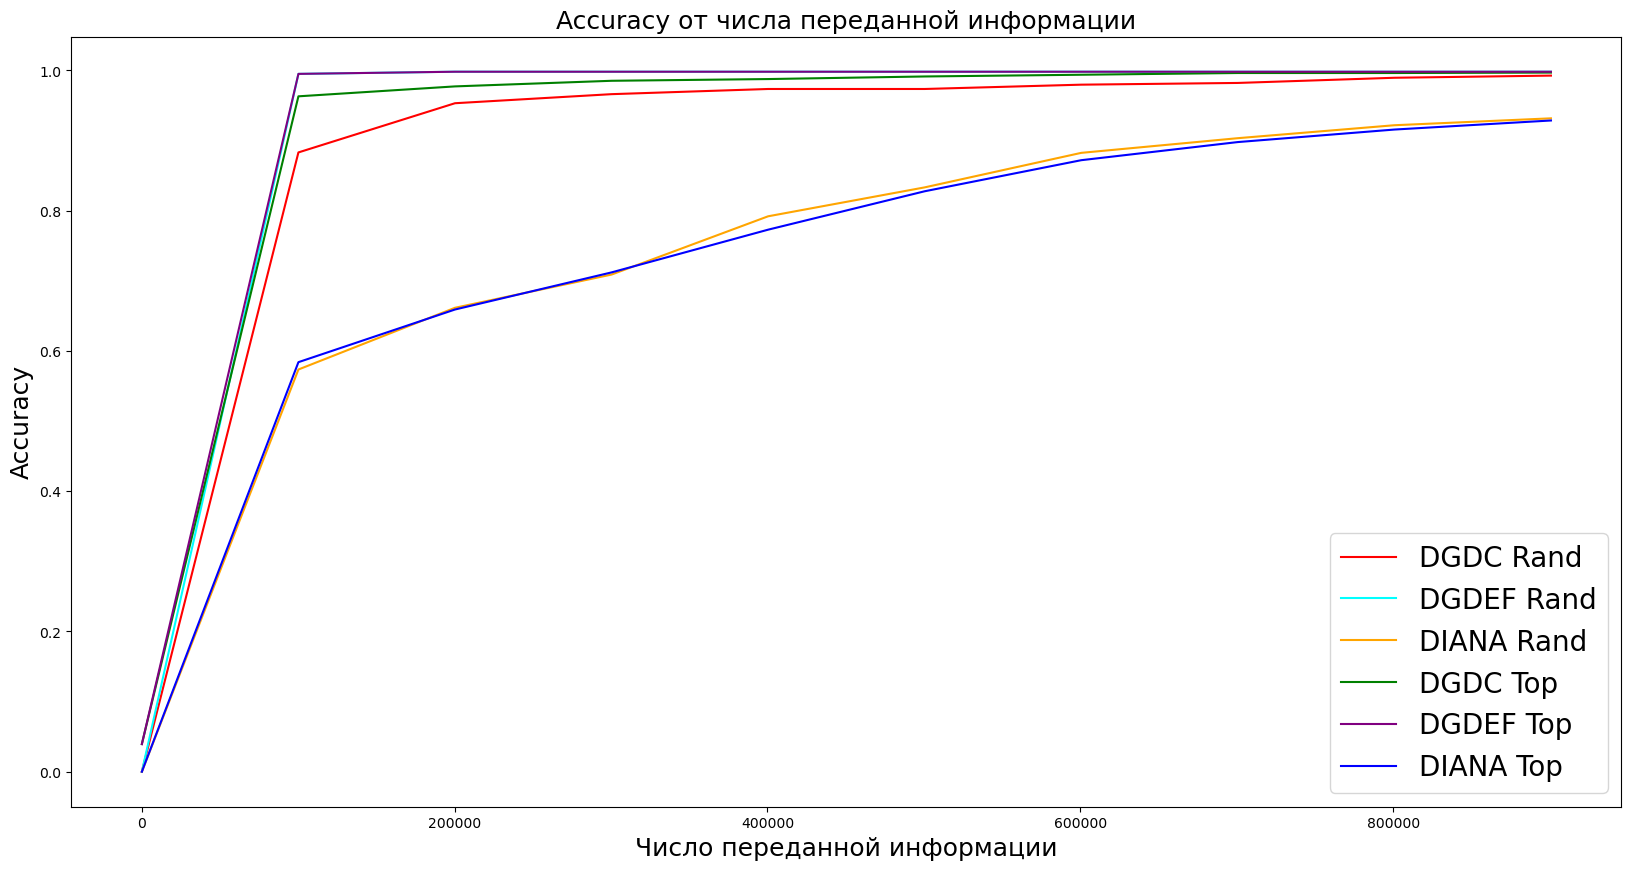

In [591]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_24) * n * m, n * m * 1001)), accuracy_1, "red", label = "DGDC Rand")
plt.plot(np.array(range(0, len(errors_25) * n * m, n * m * 1001)), accuracy_2, "cyan", label = "DGDEF Rand")
plt.plot(np.array(range(0, len(errors_26) * n * m, n * m * 1001)), accuracy_3, "orange", label = "DIANA Rand")
plt.plot(np.array(range(0, len(errors_27) * n * m, n * m * 1001)), accuracy_4, "green", label = "DGDC Top")
plt.plot(np.array(range(0, len(errors_28) * n * m, n * m * 1001)), accuracy_5, "purple", label = "DGDEF Top")
plt.plot(np.array(range(0, len(errors_29) * n * m, n * m * 1001)), accuracy_6, "blue", label = "DIANA Top")
plt.title("Accuracy от числа переданной информации", fontsize = 18)
plt.xlabel("Число переданной информации", fontsize = 18)
plt.ylabel("Accuracy", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

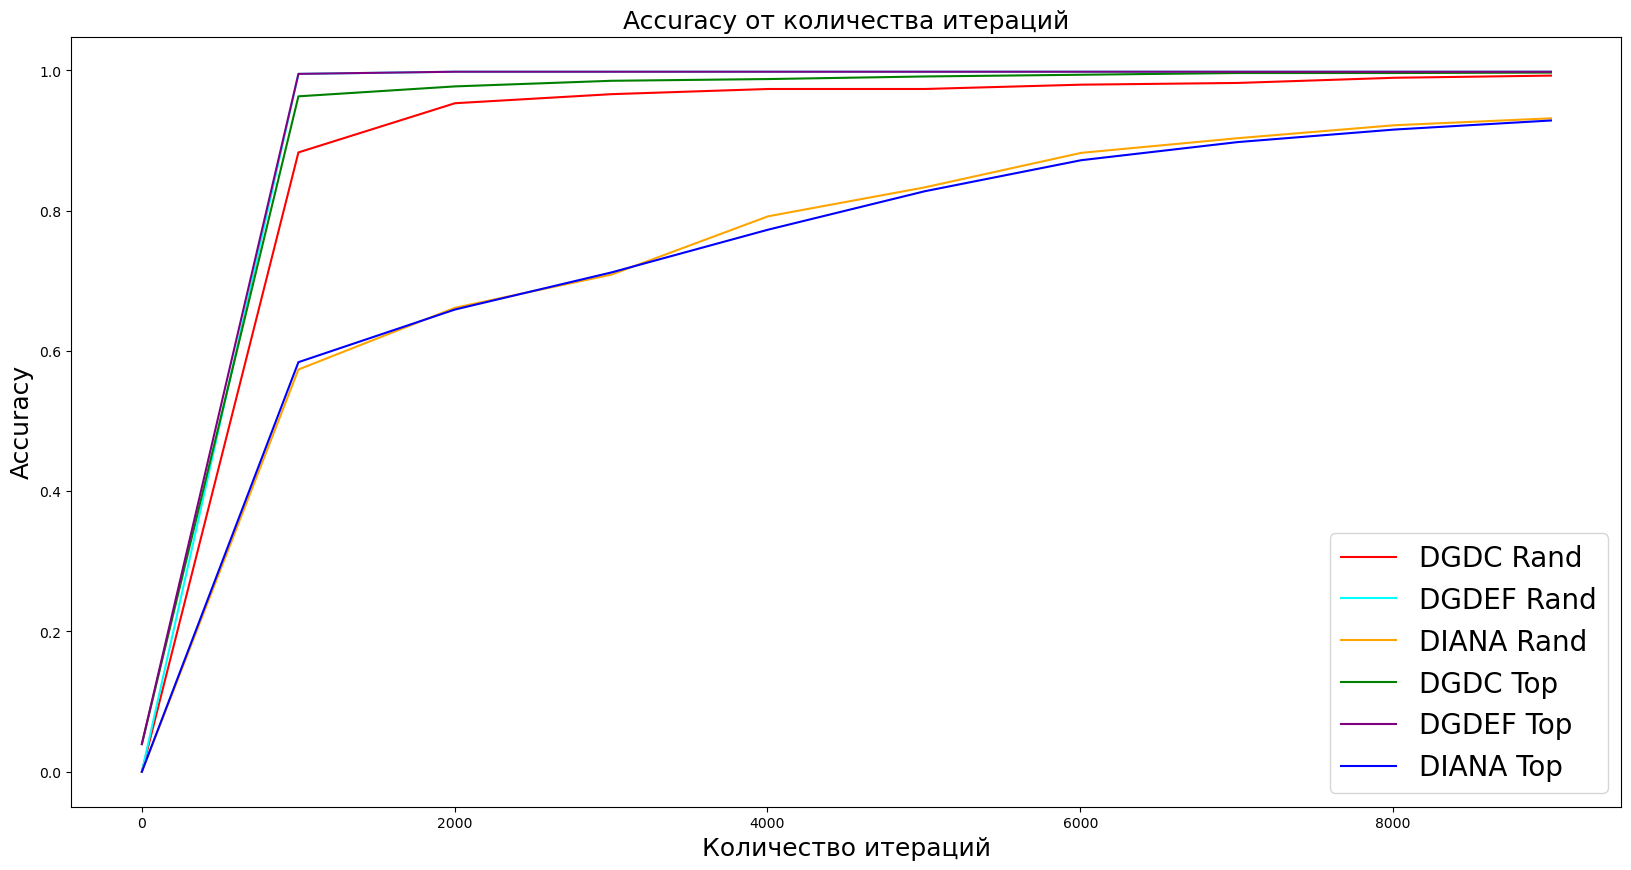

In [592]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(range(0, len(errors_24), 1001)), accuracy_1, "red", label = "DGDC Rand")
plt.plot(np.array(range(0, len(errors_25), 1001)), accuracy_2, "cyan", label = "DGDEF Rand")
plt.plot(np.array(range(0, len(errors_26), 1001)), accuracy_3, "orange", label = "DIANA Rand")
plt.plot(np.array(range(0, len(errors_27), 1001)), accuracy_4, "green", label = "DGDC Top")
plt.plot(np.array(range(0, len(errors_28), 1001)), accuracy_5, "purple", label = "DGDEF Top")
plt.plot(np.array(range(0, len(errors_29), 1001)), accuracy_6, "blue", label = "DIANA Top")
plt.title("Accuracy от количества итераций", fontsize = 18)
plt.xlabel("Количество итераций", fontsize = 18)
plt.ylabel("Accuracy", fontsize = 18)
plt.legend(fontsize = 20)
plt.show()

Вывод:

1. Все методы показали себя очень хорошо.

2. Для всех методов компрессор $\text{Top}10\%$ лучше, чем компрессор $\text{Rand}10\%$.

3. У метода DIANA скорость роста accuracy меньше, чем у всех остальных.

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

In [ ]:
#ответ

__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

In [ ]:
#ответ